In [140]:
%matplotlib inline
import os
import cv2
import numpy as np
# from pyquaternion import Quaternion as Quat # seems do not need 
from copy import deepcopy
from PIL import Image
import matplotlib.pyplot as plt
from scripts.methods.groundtruth import GroundTruth # import GroundTruth OK
from scripts.methods.model.model import ClothEdgeModel # import ClothEdgeModel OK

In [141]:
class EdgeDetector:
    def __init__(self, detection_method, crop_dims, datapath):
        self.detection_method = detection_method
        self.datapath = datapath
        self._init_model(crop_dims)
        self.depth_im = None
        self.rgb_im = None
        print("finish init")

    def _init_model(self, crop_dims):
        if self.detection_method == 'groundtruth':
            self.crop_dims = crop_dims
            self.model = GroundTruth(self.crop_dims)
        elif self.detection_method == 'network':
            self.crop_dims = crop_dims
            grasp_angle_method = 'inneredge'
            
            # grasp_angle_method 表示程序在计算抓取角度时要使用的方法
            # 如果 grasp_angle_method 为 'predict'，说明程序要使用的模型是用于预测抓取角度的模型，
            # 因此 model_path 参数将被替换为 model_angle_path 参数，即程序将使用不同的模型。
            # 否则，model_path 参数保持不变，程序将使用默认的模型。
            # 因此，这行代码的作用是根据 grasp_angle_method 的值获取正确的模型路径，并将其保存在 model_path 变量中。
            
            model_path = "/home/chimy/old_projects/cloth-segmentation-main/runspath/pretrained_weights"
            self.model = ClothEdgeModel(self.crop_dims, grasp_angle_method, model_path)

    def run(self):
        # set self.depth_im & self.rgb_im, i: index
        i = 0

        try:
            rgb_im = Image.open(os.path.join(self.datapath, "rgb_%d.png" % i))
            depth_im = np.load(os.path.join(self.datapath, "%d_depth.npy" % i))
            max_d = np.nanmax(depth_im)
            depth_im[np.isnan(depth_im)] = max_d
            print(os.path.join(self.datapath, "%d_depth.npy" % i))
        except FileNotFoundError:
            print("File not found")
        except:
            print("Failed to read file")
        
        # Prevents NaN from causing errors in image processing
        self.depth_im = np.nan_to_num(depth_im)
        self.rgb_im = cv2.imread(os.path.join(self.datapath, "rgb_%d.png" % i))

        # _server_cb content
        print("Received cloth detection request")

        rgb_im = deepcopy(self.rgb_im)  
        depth_im = deepcopy(self.depth_im)

        plt.figure(dpi=300)
        plt.subplot(121)
        plt.title("rgb_im")
        plt.imshow(rgb_im)
        plt.axis("off")
        plt.subplot(122)
        plt.title("depth_im")
        plt.imshow(depth_im)
        plt.axis("off")
        plt.show()

        # # # DetectEdgeResponse 包含以下成员变量
        # # sensor_msgs/Image rgb_im
        # # sensor_msgs/Image depth_im
        # # sensor_msgs/Image prediction
        # # sensor_msgs/Image corners
        # # sensor_msgs/Image outer_edges
        # # sensor_msgs/Image inner_edges
        response = DetectEdgeResponse()
        response.rgb_im = self.rgb_im
        response.depth_im = self.depth_im
        if self.detection_method == 'groundtruth':
            pred = self.model.predict(rgb_im)
            # pred = self.model.predict(rgb_im)
            response.prediction = pred
        elif self.detection_method == 'network':
            self.model.update() # Check if model needs to be reloaded
            corners, outer_edges, inner_edges, pred = self.model.predict(depth_im)
            print("use network, might add time later")


finish init
/home/chimy/projects/biyesheji/data_painted_towel/0_depth.npy
Received cloth detection request


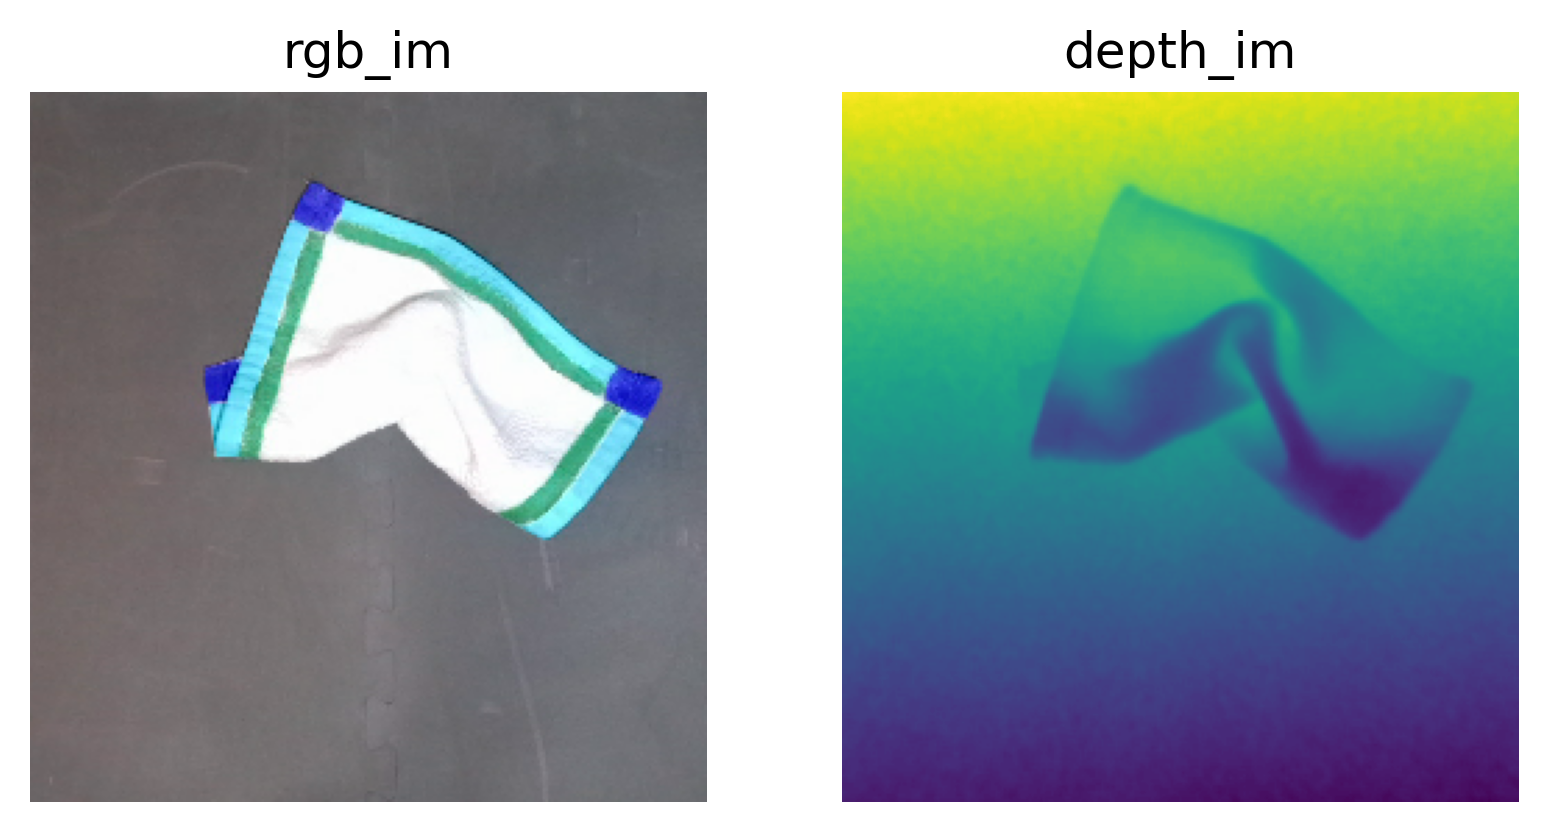

ValueError: zero-size array to reduction operation fmax which has no identity

In [142]:
detection_method = 'network'
datapath = "/home/chimy/projects/biyesheji/data_painted_towel"
crop_dims = [150, 660, 415, 900, 2]

e = EdgeDetector(detection_method, crop_dims, datapath)
e.run()